<a href="https://colab.research.google.com/github/egmmaita/KD-2nd-assignment/blob/main/KD_2nd_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Params definition

Define training parameters and install required libraries.

In [ ]:
BATCH_SIZE = 8
SEQUENCE_LENGTH = 100
EMBEDDING_SIZE = 256
RNN_SIZE = 1024

NUM_ITERS=1000

In [ ]:
!pip install mitdeeplearning -q
!apt-get -qq install abcmidi timidity > /dev/null 2>&1

     |████████████████████████████████| 2.1MB 6.9MB/s 


In [73]:
import mitdeeplearning as mdl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
np.random.seed(0)
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import os
from pathlib import Path
from matplotlib import pyplot as plt

# Dataset creation

Data preparation steps:

1.   Find MIDI files and convert to ABC (text file discribing notes)
2.   Read ABC songs and create dataset (list of songs)
3.   Create vocabolary 
4.   Preprocess songs
5.   Create batch function



### 1.   Find MIDI files and convert to ABC

In [ ]:
# !find . -name "*.abc" -type f -delete
# !find . -name "*.mid" -type f -delete
# !find . -name "*.midi" -type f -delete

rm: cannot remove 'midi_data': Is a directory
rm: cannot remove 'midi_data_jazz': Is a directory


In [ ]:
!gdown --id 1BKvGydy26B8RbgAr9X0szwWiWazJaG6C
!unzip -q midi_data.zip
!rm midi_data.zip
!wget https://github.com/egmmaita/KD-2nd-assignmment/raw/main/midi_data_jazz.zip
!unzip -q midi_data_jazz.zip
!rm midi_data_jazz.zip

Downloading...
From: https://drive.google.com/uc?id=1BKvGydy26B8RbgAr9X0szwWiWazJaG6C
To: /content/midi_data.zip
100% 566k/566k [00:00<00:00, 75.8MB/s]
--2021-05-01 14:46:20--  https://github.com/egmmaita/KD-2nd-assignmment/raw/main/midi_data_jazz.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/egmmaita/KD-2nd-assignment/raw/main/midi_data_jazz.zip [following]
--2021-05-01 14:46:20--  https://github.com/egmmaita/KD-2nd-assignment/raw/main/midi_data_jazz.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/egmmaita/KD-2nd-assignment/main/midi_data_jazz.zip [following]
--2021-05-01 14:46:20--  https://raw.githubusercontent.com/egmmaita/KD-2nd-assignment/main/midi_data_jazz.zip
Resolving raw.githubusercontent.com (raw.githubuserconten

In [ ]:
# !find . -name "*.abc" -type f -delete
!find midi_data -type f -exec midi2abc {} -o {}.abc \;
!find midi_data_jazz -type f -exec midi2abc {} -o {}.abc \;

Error: unexpected running status
Error: Time=537783 Track=2 Note terminated when not on - pitch 64
Error: Time=537971 Track=2 Note terminated when not on - pitch 64
Error: Time=538339 Track=2 Note terminated when not on - pitch 84
Error in MIDI file - notes still on at end of track!
Error: expecting MTrk
Error: Time=188166 Track=1 Note terminated when not on - pitch 64
Error: Time=188204 Track=1 Note terminated when not on - pitch 64
Error: Time=204507 Track=1 Note terminated when not on - pitch 0
Error in MIDI file - notes still on at end of track!
Error: expecting MTrk
Advancing by 0 in printtrack!
Error: Time=123473 Track=1 Note terminated when not on - pitch 100
Error: Time=126711 Track=1 Note terminated when not on - pitch 100
Error: Time=128007 Track=1 Note terminated when not on - pitch 80
Error: Time=200399 Track=1 Note terminated when not on - pitch 84
Error in MIDI file - notes still on at end of track!
Error: expecting MTrk
Error: Time=24910 Track=4 Note terminated when not 

### 2.   Read ABC songs and create dataset (list of songs)


**What is ABC notation?**

https://en.wikipedia.org/wiki/ABC_notation

ABC notation is a shorthand form of musical notation for computers. In basic form it uses the letter notation with a–g, A–G, and z, to represent the corresponding notes and rests, with other elements used to place added value on these – sharp, flat, raised or lowered octave, the note length, key, and ornamentation. 

The ABC notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo and instrument. 

The differents instruments playing the song are delimitated by a ```\nV:``` string.
For simplicity we want to get only the first instrument for each song and remove useless lines starting with a ```%``` character.

ABC file example:

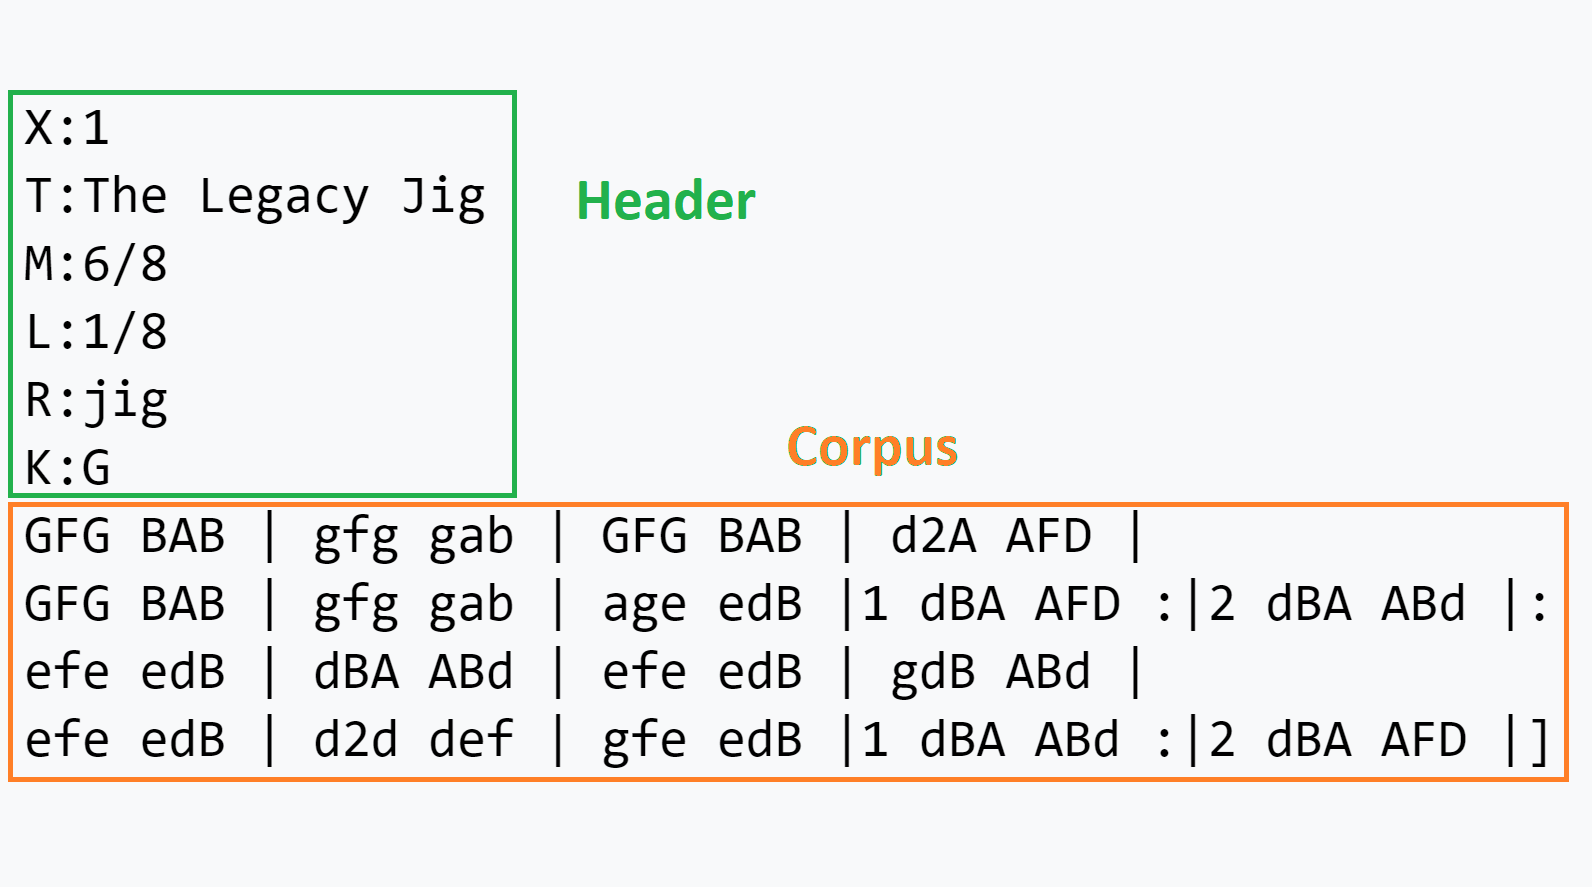

In [ ]:
def get_songs(genre_paths):
  songs = []
  for genre_path in genre_paths:
    fnames = sorted([x for x in os.listdir(genre_path) if x.endswith(".abc")])
    for fname in fnames:
       with open(Path(genre_path)/fname) as f:
         try:
            data = f.read()
            # Split song on different instruments (\nV:) and take only first
            text = data.split("\nV:")[0] + data.split("\nV:")[1]

            # Remove comments and useless lines
            list_selected_rows = []
            key_missing = True
            for row in text.split("\n"):
              if row[0]=="K" and key_missing:
                list_selected_rows.append(row)
                key_missing = False
              if row[0]!="K" and row[0] != "%" and row[0] != "w":  # remove eventual second key, lirics (w:...) and comments lines
                list_selected_rows.append(row)
            text = "\n".join(list_selected_rows)

            from_string = "from " + genre_path + "/"
            songs.append(text.replace(from_string, "").replace(".mid", ""))
         
         except:
            pass

  return songs


In [ ]:
songs = get_songs(["midi_data", "midi_data_jazz"])
print(f"The dataset consists of {len(songs)} songs.")

The dataset consists of 94 songs.


In [ ]:
#mdl.lab1.play_song(songs[0][:1000])

### 3.   Create vocabolary

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

3.1 Create a vocabulary for the songs and define numerical representation of text.

In [ ]:
# Find all unique characters in the joined string
data = songs[0]  
all_other_songs = songs[1:]
for song in all_other_songs:
  data += "\n\n\n\n" + song
characters = [character for character in data if len(character)>0]
vocab = list(set(characters))

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
# we can evaluate `char2idx["d"]`.  
char2idx = {character: idx for idx,character in enumerate(vocab)}

# Create a mapping from indices to characters. This is
# the inverse of char2idx and allows us to convert back
# from unique index to the character in our vocabulary.
idx2char = {idx: character for idx,character in enumerate(vocab)}

3.2 Create a vocabulary of the song keys to be provided, as additional input, to the model in order to control the song generation.

In [77]:
# Extract keys
rows = ("\n".join(songs)).split("\n")
keys = sorted(list(set([x.split(" ")[0][2:] for x in rows if x[:2] == "K:"])))

# Create keys vocabulary
key2idx = {key: idx for idx,key in enumerate(keys)}
idx2key = {idx: key for idx,key in enumerate(keys)}

### 4. Preprocessing songs

Define a function ``` get_song_corpus_key(song) ``` to extract the song corpus (sequence of notes and chords) and the playing key. The output is a dict containing both the corpus and the key for the passed song. 

In [78]:
def get_song_corpus_key(string):
  # Split song lines
  splitted_string = string.split("\n")

  # Get song header (title, time, key, ...)
  header = splitted_string[:6]
  key = [x.split(" ")[0][2:] for x in header if x[:2] == "K:"][0]

  # Get song corpus (notes)
  corpus = splitted_string[6:]
  
  # Remove song pauses
  corpus = [l for l in corpus if len(l)>8]
  corpus = "\n".join(corpus)

  return {"key": key, "song": corpus}

Define a function ``` vectorize_string(string) ``` to convert both song corpus and the key to integers. The function internally calls the ``` get_song_corpus_key(song) ``` function to receive extract the two requirede elements for the passed song and than has to convert them to integers using the created vocabularies.

**TODO**: convert both the key and each character of the song corpus to a int. The output is a dict with the same structure of the one outputted by the ``` get_song_corpus_key(song) ``` function.

In [79]:
def vectorize_string(string):
  # Get song corpus and key
  song_dict = get_song_corpus_key(string)
  key = song_dict["key"]
  song = song_dict["song"]

  int_key = key2idx[key]
  vectorized_output = [char2idx[character] for character in song]

  song_dict = {"key": int_key, "song": vectorized_output}
  
  return song_dict

In [80]:
# Convert songs to their vector representation using the created function
vec_songs = [vectorize_string(x) for x in songs]

### 5. Get batch

In our text file, we saw that a song is a block of text that we converted int a vector representation. Each song has its own length. However, dealing with different sequence lengths may be difficult. For simplicity, when generating a batch, we will just get `N` random songs from our dataset, where N is the batch size. 

Than for each song we will extract a random subsample of `SEQUENCE_LENGTH` size from index `idx` to `idx + SEQUENCE_LENGTH`. For each input, the corresponding target will contain the same length of elements, except shifted one character to the right.

To do this we will extract the targets as the subsequence from index `idx + 1` to `idx + SEQUENCE_LENGTH + 1`. Suppose `SEQUENCE_LENGTH` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

In [ ]:
### Batch definition to create training examples ###

def get_batch(vec_songs, seq_length, batch_size):

  sampled_songs = np.random.choice(vec_songs, size = batch_size) 
  in_batch = []
  keys_batch = []
  tar_batch = []

  for song_dict in sampled_songs:
    key = song_dict["key"]
    song = song_dict["song"]
    idx = np.random.randint(0,len(song)-seq_length-1)... # idx is a random index in range [0, len(song) - seq_length - 1]  choose safe range
    in_batch.append(song[idx: idx + seq_length])
    keys_batch.append(key)
    tar_batch.append(song[idx + 1 : idx + seq_length + 1])
  
  in_batch = torch.LongTensor()
  keys_batch = ... #TODO
  keys_batch = keys_batch.unsqueeze(1)
  tar_batch = ... #TODO


    # for i in range(num_batch_groups):
    #     # Get the scenes in this group
    #     group_scene_inputs = scene_inputs[i*batch_size:(i+1)*batch_size]
    #     group_scene_targets = scene_targets[i*batch_size:(i+1)*batch_size]
    #     # Build batches for each mini-sequence
    #     for j in range(num_mini_sequences):
    #         reset_state = (j == 0)
    #         batch_inputs = torch.LongTensor([group_scene_inputs[k][j] for k in range(batch_size)])
    #         batch_targets = torch.LongTensor([group_scene_targets[k][j] for k in range(batch_size)])
    #         batches.append((reset_state, batch_inputs, batch_targets))

  return in_batch, keys_batch, tar_batch

In [ ]:
in_batch, keys_batch, tar_batch = get_batch(vec_songs, SEQUENCE_LENGTH, BATCH_SIZE)
print(in_batch.shape)
print(keys_batch.shape)
print(tar_batch.shape)

# Music Generator

Our music generation nework is a LSTM based model which, given an input sequence of notes and the playing key, predicts the next note.

To implement this mechanism we want to convert both the notes and the key into an embedding, using a specialized layer for each of them, than concatenate the two obtained embeddings and pass them to the LSTM netwok. Finally a Linear layer predicts the next note.

**TODO**: 

1.   Create a `nn.Embedding` layer wich receives the **notes**, belonging to a `NUM_NOTES` sized vocabulary and produce an `EMBEDDING_SIZE` embedding.
2.   Create a `nn.Embedding` layer wich receives the **keys**, belonging to a `NUM_KEYS` sized vocabulary and produce an `EMBEDDING_SIZE` embedding.
3.   Create a `N` layers `nn.LSTM` wich receives an `EMBEDDING_SIZE * 2` sized input (we want to concatenate the embeddings coming from the notes and the keys).
4.   Create a final decoder predicting the next note (as a classifies 😉)

**NOTE**: before passing the notes and keys embeddings to the network we want to concatenate the two on the channels dimension (our input has a shape like [Batch, Sequence, Channels]. As the number of elements is different (you have only one key for a `SEQUENCE_LENGTH` sequence of notes) you have to replicate the keys on the sequence dimension (1) to have a size according to the length of your sequence `keys_embedding.repeat(1, SEQUENCE_LENGTH, 1)`


In [ ]:
class MusicGenerator(nn.Module):
    
    def __init__(self, vocab_size, num_keys, embed_size, rnn_size):
        # params: 
        # vocab_size: the number of the input vocabulary
        # num_keys: the number of the keys vocabulary
        # embed_size: the size of the feature embedding
        # rnn_size: the number of neurons in the recurrent layer

        # TODO: create network layers


    def reset_state(self):
        # Mark next state to be re-initialized
        self.reset_next_state = True
    
    def forward(self, x, keys):
        # Implement forward pass (state reset, input embedding, ...)
        return x

In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MusicGenerator(len(vocab), len(keys), EMBEDDING_SIZE, RNN_SIZE).to(dev)

In [ ]:
in_batch, keys_batch, tar_batch = get_batch(vec_songs, SEQUENCE_LENGTH, BATCH_SIZE)
pred = model(in_batch.to(dev), keys_batch.to(dev))
print(pred.shape)

In [ ]:
# Get next value prediction
val, index = pred[0, -1].max(0)

print(index, val)

# Training procedure

In [ ]:
def train(model, optim, criterion, dataset, dev=torch.device('cpu')):
  try:
    model.to(dev)

    # Initialize training history
    loss_history = []

    # Set network mode
    model.train()

    for iter in range(NUM_ITERS):
      # reset model state 
      model.reset_state()

      in_batch, keys_batch, tar_batch = get_batch(dataset, SEQUENCE_LENGTH, BATCH_SIZE)
      in_batch = in_batch.to(dev)
      keys_batch = keys_batch.to(dev)
      tar_batch = tar_batch.to(dev)

      output = model(in_batch, keys_batch)

      # Implement training
      # 1. Forward through network
      # 2. Compute loss
      # 4. Backward loss
      # 5. Update params

      # Print info
      print(f"Iter: {iter+1}, loss: {loss_history[-1]:.4f}")
  except KeyboardInterrupt:
    print("Interrupted")
  finally: 
    # Plot loss
    plt.title("loss")
    plt.plot(loss_history, label="Train")
    plt.legend()
    plt.show()
    

In [ ]:
criterion = ... #define a loss
optimizer = ... #define an optimizer

In [ ]:
train(model, optimizer, criterion, vec_songs, dev=dev)

In [ ]:
def generate_text(model, start_string, key, generation_length=1000):
  with torch.no_grad():
    input_eval = [char2idx[s] for s in start_string]
    # convert to tensor and add the batch dim
    input_eval = torch.tensor(input_eval).unsqueeze(0).to(dev)


    key = [keys2idx[key]]
    key = torch.tensor(key, dtype=torch.long).unsqueeze(0).to(dev)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_state()

    for i in tqdm(range(generation_length)):
      predictions = model(input_eval, key)[:, -1:, :]
      # predictions shape : 1 x 1 x vocab_size
      
      # Get the predicted id
      predicted_id = predictions[0].max(1)[1]

      # Prepare the next input and add the batch dimension
      input_eval = predicted_id.unsqueeze(dim = 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
# {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'Gb': 6}
start_string = "FG FE|"
key="Gb"
header = "X: 1\nT: KD-Course-2021\nM: 4/4\nL: 1/8\nQ:1/4=117\nK:C % 0 sharps\n\n"

out = generate_text(model, start_string, key, generation_length=1000)
gen_song = header + out

print(gen_song)

In [ ]:
mdl.lab1.play_song(gen_song)